**HW2. TicTacToe**

In [1]:
import gym
import numpy as np
from tqdm import tqdm
import math
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from service import plot_policy_rewards
from TicTacToeClass import TicTacToe
from models import Policy
from models import NNQ
from models import NNQ_Dueling
from models import DQN
from models import DoubleDQN
from Learner import Learner, learn

device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')

C:\Users\Mikhail Korotkov\.conda\envs\dl_made_env\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


**Часть первая: крестики-нолики при помощи Q-обучения**

В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.  

1.   Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3
2.   Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5

Q-обучение

In [2]:
alpha = 0.009
epsilon = 0.3
gamma = 1.0

env_33 = TicTacToe(3, 3, 3)
env_44 = TicTacToe(4, 4, 4)

pi1_33 = Policy()
pi1_33.set_learning_params(alpha, epsilon, gamma)
pi2_33 = Policy()
pi2_33.set_learning_params(alpha, epsilon, gamma)
pi1_44 = Policy()
pi1_44.set_learning_params(alpha, epsilon, gamma)
pi2_44 = Policy()
pi2_44.set_learning_params(alpha, epsilon, gamma)

learner_33 = Learner(env_33, pi1_33, pi2_33)
learner_44 = Learner(env_44, pi1_44, pi2_44)

epochs33 = []
crosses33 = []
zeros33 = []
epochs44 = []
crosses44 = []
zeros44 = []

In [3]:
total_episodes = 1000000
test_episodes = 1000
for i in tqdm(range(1, total_episodes + 1)):
    learner_33.game_train()
    if i % test_episodes == 0:
        reward = learner_33.get_policy_reward(pi1_33, None, n_episodes=500)
        crosses33.append(reward)
        reward = -learner_33.get_policy_reward(None, pi2_33, n_episodes=500)
        zeros33.append(reward)
        epochs33.append(i)

100%|███████████████████████████████████████████████████████████████████████| 1000000/1000000 [17:46<00:00, 937.28it/s]


In [4]:
total_episodes = 1500000
test_episodes = 1000
for i in tqdm(range(1, total_episodes + 1)):
    learner_44.game_train()
    if i % test_episodes == 0:
        reward = learner_44.get_policy_reward(pi1_44, None, n_episodes=500)
        crosses44.append(reward)
        reward = -learner_44.get_policy_reward(None, pi2_44, n_episodes=500)
        zeros44.append(reward)
        epochs44.append(i)

100%|█████████████████████████████████████████████████████████████████████| 1500000/1500000 [1:11:40<00:00, 348.76it/s]


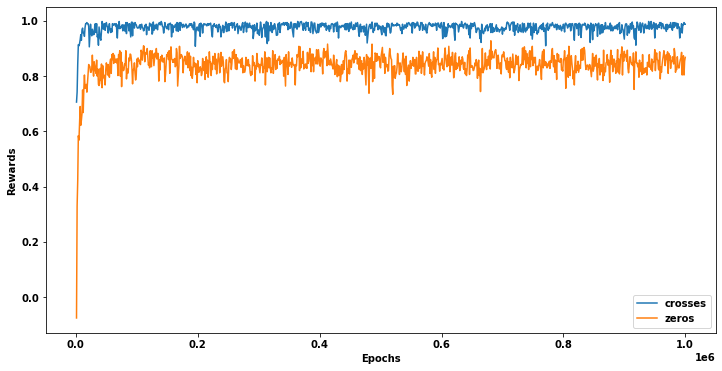

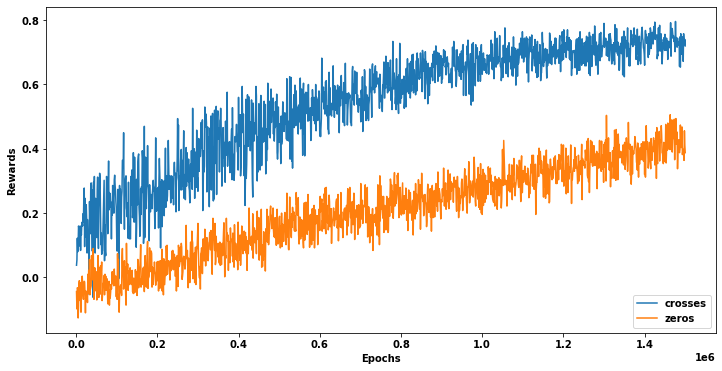

In [5]:
# Для доски 3 на 3
plot_policy_rewards(epochs33, crosses33, zeros33)
# Для доски 4 на 4
plot_policy_rewards(epochs44, crosses44, zeros44)

**Часть вторая: добавим нейронных сетей**

Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).


1.   Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.
2.  Реализуйте Double DQN и/или Dueling DQN.





DQN для доски 3 на 3

In [19]:
n_rows, n_cols, n_win = 3, 3, 3
epochs33, n_episodes33, period = 40000, 1000, 1000

channels_in = [3]
channels_out = [128]

linear_in = [128, 64]
linear_out = [64, 9]

kernels = [3]

nn_zeros = NNQ(channels_in, channels_out, kernels, linear_in, linear_out)
nn_crosses = NNQ(channels_in, channels_out, kernels, linear_in, linear_out)

learner_33 = DQN([nn_zeros, nn_crosses], n_rows, n_cols, n_win)

crosses33, zeros33 = learn(learner_33, epochs33, n_episodes33, period)

100%|██████████| 40000/40000 [21:41<00:00, 30.72it/s]


DQN для доски 4 на 4

In [20]:
n_rows, n_cols, n_win = 4, 4, 4
epochs44, n_episodes44, period = 25000, 1000, 1000

channels_in = [3, 128 ]
channels_out = [128, 256]

linear_in = [256, 128]
linear_out = [128, 16]

kernels = [3, 2]

nn_zeros = NNQ(channels_in, channels_out, kernels, linear_in, linear_out)
nn_crosses = NNQ(channels_in, channels_out, kernels, linear_in, linear_out)

learner_44 = DQN([nn_zeros, nn_crosses], n_rows, n_cols, n_win)

crosses44, zeros44 = learn(learner_44, epochs44, n_episodes44, period)

100%|██████████| 25000/25000 [25:24<00:00, 16.40it/s]


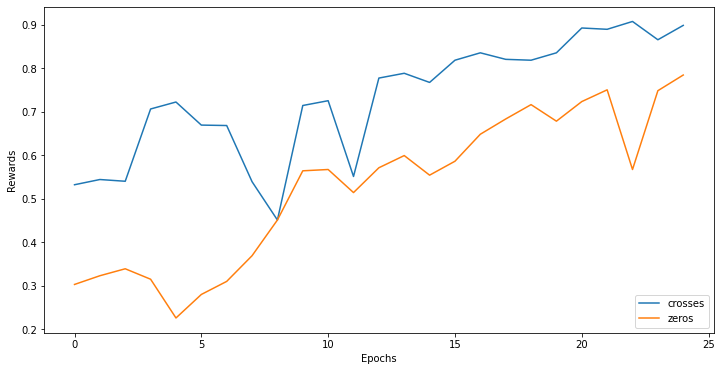

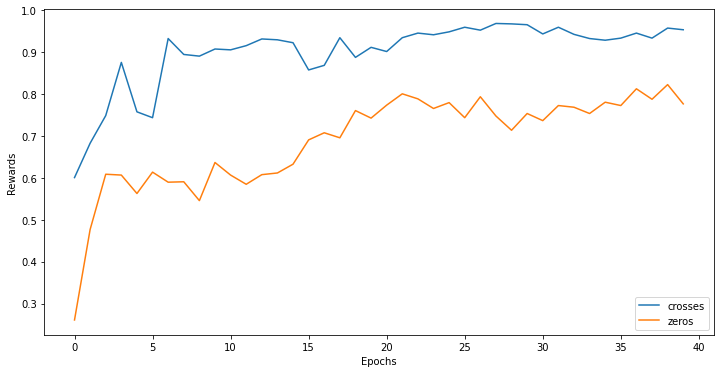

In [21]:
# Для доски 3 на 3
plot_policy_rewards(range(epochs44 // n_episodes44), crosses44, zeros44)
# Для доски 4 на 4
plot_policy_rewards(range(epochs33 // n_episodes33), crosses33, zeros33)

Double DQN для доски 3 на 3

In [22]:
n_rows, n_cols, n_win = 3, 3, 3
epochs33, n_episodes33, period = 25000, 1000, 1000

channels_in = [3]
channels_out = [128]

linear_in = [128, 64]
linear_out = [64, 9]

kernels = [3]

nn_zeros = NNQ(channels_in, channels_out, kernels, linear_in, linear_out)
nn_crosses = NNQ(channels_in, channels_out, kernels, linear_in, linear_out)
nn_zeros_target = NNQ(channels_in, channels_out, kernels, linear_in, linear_out)
nn_crosses_target = NNQ(channels_in, channels_out, kernels, linear_in, linear_out)

double_learner_33 = DoubleDQN([nn_zeros, nn_crosses], [nn_zeros_target, nn_crosses_target], n_rows, n_cols, n_win)

crosses33, zeros33 = learn(double_learner_33, epochs33, n_episodes33, period)

100%|██████████| 25000/25000 [13:57<00:00, 29.84it/s]


In [ ]:
# plot_policy_rewards(range(epochs33 // n_episodes33), crosses33, zeros33)

Double DQN для доски 4 на 4

In [25]:
n_rows, n_cols, n_win = 4, 4, 4
epochs44, n_episodes44, period = 15000, 1000, 1000

channels_in = [3, 128]
channels_out = [128, 256]

linear_in = [256, 128]
linear_out = [128, 16]

kernels = [3, 2]

nn_zeros = NNQ(channels_in, channels_out, kernels, linear_in, linear_out)
nn_crosses = NNQ(channels_in, channels_out, kernels, linear_in, linear_out)
nn_zeros_target = NNQ(channels_in, channels_out, kernels, linear_in, linear_out)
nn_crosses_target = NNQ(channels_in, channels_out, kernels, linear_in, linear_out)

double_learner_44 = DoubleDQN([nn_zeros, nn_crosses], [nn_zeros_target, nn_crosses_target], n_rows, n_cols, n_win)

crosses44, zeros44 = learn(double_learner_44, epochs44, n_episodes44, period)

100%|██████████| 15000/15000 [15:34<00:00, 16.06it/s]


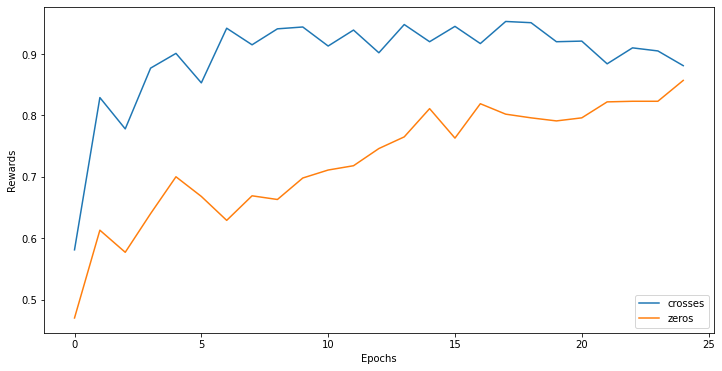

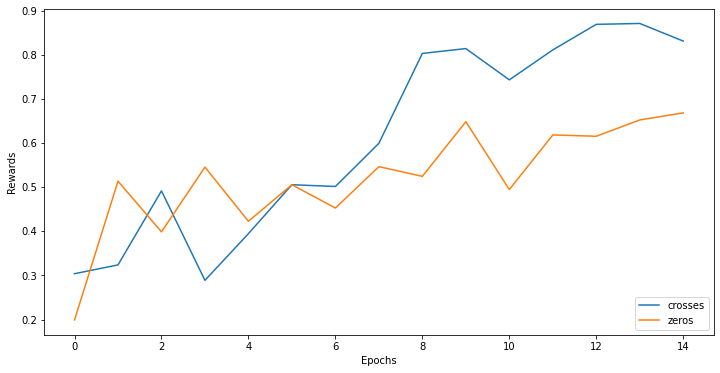

In [26]:
# Для доски 3 на 3
plot_policy_rewards(range(epochs33 // n_episodes33), crosses33, zeros33)
# Для доски 4 на 4
plot_policy_rewards(range(epochs44 // n_episodes44), crosses44, zeros44)

NNQ_Dueling для доски 4 на 4

In [27]:
n_rows, n_cols, n_win = 4, 4, 4
epochs, n_episodes, period = 15000, 1000, 1000

channels_in = [3, 128]
channels_out = [128, 256]

linear_in = [256, 128]
linear_out = [128, 16]

kernels = [3, 2]

nn_zeros = NNQ_Dueling(channels_in, channels_out, kernels, linear_in, linear_out)
nn_crosses = NNQ_Dueling(channels_in, channels_out, kernels, linear_in, linear_out)
nn_zeros_target = NNQ_Dueling(channels_in, channels_out, kernels, linear_in, linear_out)
nn_crosses_target = NNQ_Dueling(channels_in, channels_out, kernels, linear_in, linear_out)

dueling_double_learner_44 = DoubleDQN([nn_zeros, nn_crosses], [nn_zeros_target, nn_crosses_target], n_rows, n_cols, n_win)

crosses, zeros = learn(dueling_double_learner_44, epochs, n_episodes, period)

100%|██████████| 15000/15000 [17:10<00:00, 14.55it/s]


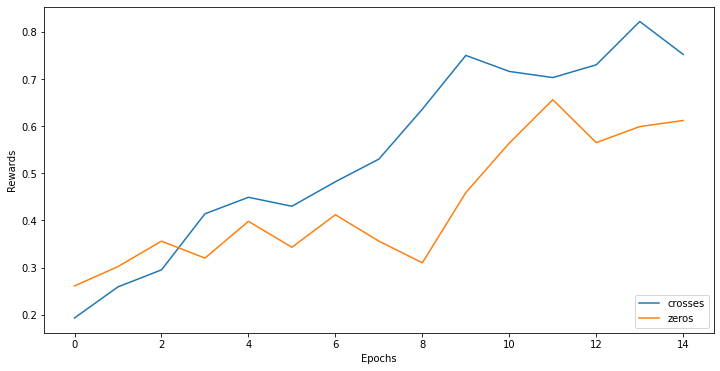

In [28]:
plot_policy_rewards(range(epochs // n_episodes), crosses, zeros)